In [ ]:
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import cv2

# from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
# from tensorflow.python.keras.applications.resnet import ResNet50, preprocess_input 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
# from tensorflow.python.keras.applications.efficientnet import EfficientNetB6, preprocess_input 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define the folder paths

In [ ]:
base_dir = "/content/drive/My Drive/Seed_dataset"

train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')
test_dir = os.path.join(base_dir, 'test')

### Check the distribution of the various classes for train, test and validation datasets

In [ ]:
def show_distribution(folder):
    
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_directory(folder)

    counter = Counter(generator.classes)                          
    total_images = sum(counter.values())
    distribution = [(class_id,round(num_images / total_images * 100,2)) for class_id, num_images in counter.items()]

    for class_id, percentage in distribution:
        print(class_id, percentage)


In [ ]:
print("The distribution for the training data is :\n")
show_distribution(train_dir)

The distribution for the training data is :

Found 1287 images belonging to 6 classes.
0 13.99
1 21.13
2 16.16
3 25.49
4 11.34
5 11.89


In [ ]:
print("The distribution for the validation data is :\n")
show_distribution(val_dir)

The distribution for the validation data is :

Found 389 images belonging to 6 classes.
0 14.65
1 23.14
2 14.91
3 25.19
4 11.31
5 10.8


In [ ]:
print("The distribution for the test data is :\n")
show_distribution(test_dir)

The distribution for the test data is :

Found 412 images belonging to 6 classes.
0 14.56
1 21.84
2 16.5
3 24.27
4 11.17
5 11.65


### Dealing with imbalanced classes

We can see that the distributions are not balanced. Hence we would need to use ways to work with imbalanced data while training the model. One option is to use **"class_weights"**

Let us calculate the appropriate class weights

In [ ]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_dir)

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
print("\nThe class weights are : \n\n", class_weights)

Found 1287 images belonging to 6 classes.

The class weights are : 

 {0: 1.8222222222222222, 1: 1.2058823529411764, 2: 1.5769230769230769, 3: 1.0, 4: 2.2465753424657535, 5: 2.1437908496732025}


## Build the model

In [ ]:
NUM_CLASSES = 6
IMAGE_SIZE=[224, 224]
BATCH_SIZE=32

In [ ]:
# Create the Generators
train_val_generator = ImageDataGenerator(
                                        preprocessing_function=preprocess_input,    
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest'
                                        )


# Train data generator
train_data = train_val_generator.flow_from_directory(train_dir, 
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True
                                                    )

# Validation data generator
val_data = train_val_generator.flow_from_directory(val_dir, 
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  shuffle=True
                                                  )

# Test data generator
test_generator  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_generator.flow_from_directory(test_dir, 
                                               target_size=IMAGE_SIZE,
                                               batch_size=1,
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False
                                               )

Found 1287 images belonging to 6 classes.
Found 389 images belonging to 6 classes.
Found 412 images belonging to 6 classes.


### Adding ReduceLROnPlataeau & Early Stopping

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# we will use adam
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_data,
         validation_data = val_data,
         epochs = 50,
         callbacks = [reduce_lr, early_stopping])

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use Adam
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit(train_data,
                   validation_data = val_data,
                   epochs = 50,
                   callbacks = [reduce_lr, early_stopping])

Epoch 1/50
41/41 [==============================] - 468s 11s/step - loss: 1.0091 - accuracy: 0.6698 - val_loss: 0.4836 - val_accuracy: 0.8483 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - 77s 2s/step - loss: 0.4275 - accuracy: 0.8531 - val_loss: 0.5774 - val_accuracy: 0.8123 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 78s 2s/step - loss: 0.3130 - accuracy: 0.8881 - val_loss: 0.3759 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 79s 2s/step - loss: 0.2923 - accuracy: 0.8998 - val_loss: 0.3529 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 77s 2s/step - loss: 0.2720 - accuracy: 0.9091 - val_loss: 0.4941 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - 79s 2s/step - loss: 0.2522 - accuracy: 0.9106 - val_loss: 0.4035 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - 77s 2s/step - loss: 0.2290 -

### Graphs

### Training/Testing Accuracies VS Training/Testing Losses

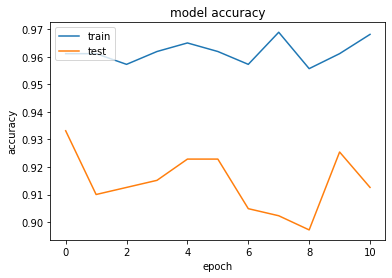

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

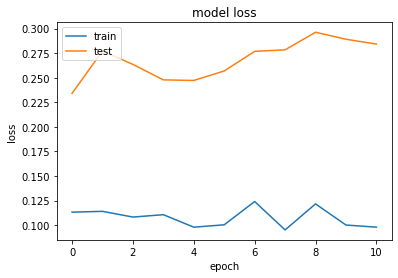

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()